In [11]:
import pandas as pd
import numpy as np

## step 1. Crawling comments from Youtube url

    - input: specific Youtube url 

    - output: dataframe (id, comments, likes)

* reference: [SeleniumÏùÑ Ïù¥Ïö©Ìï¥ Youtube ÎåìÍ∏Ä Í∞ÄÏ†∏Ïò§Í∏∞](https://somjang.tistory.com/entry/PythonSelenium%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%98%EC%97%AC-%EC%9C%A0%ED%8A%9C%EB%B8%8C-%EB%8C%93%EA%B8%80-%EA%B0%80%EC%A0%B8%EC%98%A4%EA%B8%B0

    - Í∏∞Ï°¥ [Youtube-Comment-Crawler](https://github.com/SOMJANG/Youtube_Comment_Crawler) Î≥¥ÏôÑ
        - MacÏóêÏÑú ÎèåÏïÑÍ∞ÄÏßÄ ÏïäÏïòÏùå
        - Ï¢ãÏïÑÏöî Í∞úÏàò ÏàòÏßëÌïòÏßÄ Î™ªÌñàÏùå

In [2]:
! pip install selenium

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [6]:
! brew install chromedriver

/bin/sh: brew: command not found


In [12]:
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait # available since 2.4.0
from selenium.webdriver.support import expected_conditions as EC # available since 2.26.0
import time
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re

In [13]:
# for test new webdriver
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver') # chromedriver ÏÑ§Ïπò ÌõÑ, /usr/local/bin/ÏúºÎ°ú ÏòÆÍ≤®Ï§òÏïº Ìï® 
driver.get('http://www.google.com/xhtml');
time.sleep(5)

search_box = driver.find_element_by_name('q')
search_box.send_keys('ChromeDriver')
search_box.submit()
time.sleep(5)

driver.quit()

In [121]:
def get_urls_from_youtube_with_keyword(keyword):
    titles = []
    urls = []   
    search_keyword_encode = requests.utils.quote(keyword)    
    url = "https://www.youtube.com/results?search_query=" + search_keyword_encode    
    driver = wd.Chrome(executable_path="chromedriver.exe")    
    driver.get(url)    
    last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")        
        time.sleep(3.0)        
        new_page_height = driver.execute_script("return document.documentElement.scrollHeight")        
        if new_page_height == last_page_height:
            break
            
        last_page_height = new_page_height        
    html_source = driver.page_source    
    driver.quit()    
    soup = BeautifulSoup(html_source, 'lxml')    
    datas = soup.select("a#video-title")
    for data in datas:
        title = data.text.replace('\n', '')
        url = "https://www.youtube.com/" + data.get('href')        
        titles.append(title)
        urls.append(url)
        
    return titles, urls

In [14]:
def crawl_youtube_page_html_sources(url):
    html_sources = []
    for i in range(5):
        driver = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver') # chromedriver ÏÑ§Ïπò ÌõÑ, /usr/local/bin/ÏúºÎ°ú ÏòÆÍ≤®Ï§òÏïº Ìï® 
        driver.get(url)
        time.sleep(5)
        last_page_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            time.sleep(5)
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight-50);")
            time.sleep(5)
            new_page_height = driver.execute_script("return document.body.scrollHeight")
            if new_page_height == last_page_height: # ÏÉàÎ°ú Î°úÎìú Îêú ÌéòÏù¥ÏßÄÏùò Í∏∏Ïù¥ÏôÄ, ÌéòÏù¥ÏßÄÏùò ÏµúÎåÄ Í∏∏Ïù¥Í∞Ä Í∞ôÏïÑÏßà ÎñÑ 
                break
            last_page_height = new_page_height
        html_source = driver.page_source
        html_sources.append(html_source)
        driver.quit()
    return html_sources

In [22]:
def get_user_IDs_and_comments(html_sources):
    my_dataframes = []
    for html in html_sources:
        
        soup = BeautifulSoup(html, 'lxml')
        if not soup: break
        total_comments = soup.find("yt-formatted-string", class_ ="count-text style-scope ytd-comments-header-renderer").text
        print('Ï¥ù', end = '')
        print(total_comments)
        youtube_user_IDs = soup.select('div#header-author > a > span')
        youtube_comments = soup.select('yt-formatted-string#content-text') ##content-text > span:nth-child(1) 
        youtube_likes = soup.select('div#toolbar > span#vote-count-middle')

        str_youtube_userIDs = []
        str_youtube_comments = []
        str_youtube_likes = []

        for i in range(len(youtube_user_IDs)):
            # user id 
            str_tmp = str(youtube_user_IDs[i].text)
            str_tmp = str_tmp.replace('\n', ' ')
            str_tmp = str_tmp.replace('\t', ' ')
            str_tmp = str_tmp.replace('                ',' ')
            str_youtube_userIDs.append(str_tmp)
            # comments
            str_tmp = str(youtube_comments[i].text) 
            str_tmp = str_tmp.replace('\n', '')
            str_tmp = str_tmp.replace('\t', '')
            str_tmp = str_tmp.replace('               ', ' ')
            str_youtube_comments.append(str_tmp)
            # likes
            str_tmp = str(youtube_likes[i].text)
            str_tmp = str_tmp.replace('\n', '')
            str_tmp = str_tmp.replace('\t', '')
            str_tmp = str_tmp.replace('               ', ' ')
            str_youtube_likes.append(str_tmp)
            
        pd_data = {"ID":str_youtube_userIDs, "Like": str_youtube_likes , "Comment":str_youtube_comments}
        youtube_pd = pd.DataFrame(pd_data)
        my_dataframes.append(youtube_pd)
        
    return my_dataframes

In [16]:
def crawling_url(url):
    html_sorces = crawl_youtube_page_html_sources(urls)
    my_df = get_user_IDs_and_comments(html_sorces)
    df = my_df[0]
    for i in range(1,len(my_df)):
        df = pd.concat([df, my_df[i]])
    df = df.drop_duplicates()        
    return df 

In [17]:
def count_like(df):
    # change str to num
    likes = list(df['Like'])
    for i in range(len(likes)):
        likes[i] = likes[i].replace(' ','')
        if likes[i][-1] == 'Ï≤ú': 
            likes[i] = float(likes[i][:-1])*1000
        elif likes[i][-1] == 'Îßå': 
            likes[i] = float(likes[i][:-1])*10000
        else: likes[i] = float(likes[i])
        likes[i]+=1
    df['Like'] = likes
    return df

In [186]:
urls = 'https://www.youtube.com/watch?v=bscDxrb6lcU'
cmts = crawling_url(urls) # comments output after crawling
cmts = count_like(cmts) # change likes (string -> num)

Ï¥ùÎåìÍ∏Ä 188Í∞ú
Ï¥ùÎåìÍ∏Ä 188Í∞ú
Ï¥ùÎåìÍ∏Ä 188Í∞ú
Ï¥ùÎåìÍ∏Ä 188Í∞ú
Ï¥ùÎåìÍ∏Ä 188Í∞ú


In [187]:
cmts

ID   Like  \
0                 no pain yes gain             117.0   
1                           MNZ ML              85.0   
2                         ÎèÑÎ†àÎØ∏ÌååÏÜîÎùºÏãúÎèÑ              30.0   
3                             asdf              45.0   
4                              ÏñÑÎùºÎ¶¨              19.0   
..                                        ...    ...   
115                           Ïù¥Î¶ÑÏóÜÏùå               0.0   
116                         gdd og               2.0   
117                     Chat Yejun               0.0   
118                           ÏßàÎüâÎ≥¥Ï°¥               1.0   
119                  Yoon Jae Jang               1.0   

                                               Comment  
0                     Ïß¨ÎΩïÎùºÎ©¥ ÏßÑÏß¨ÎΩïÏúºÎ°ú ÏòÆÍπÅÎãàÎã§. ÌôîÏÇ¨Í∞Ä Î®πÏúºÎ©¥ Î≠êÎì†ÏßÄ Í∞úÎï°ÍπÄ  
1            Ìóê ÌôîÏÇ¨Í∞Ä Î™®Îç∏ÏûÑ? Ï†ïÎßê Í¥ëÍ≥†Í≥ÑÏùò Î∏îÎ£®Ïπ©Ïù¥Îã§„Öã„Öã„Öã„Öã„Öã„Öã„Öã ÏÇ¨Î®πÏñ¥Î¥êÏïºÏßÄ...  
2    Î©¥ÏπòÍ∏∞ Ìï†Îïå ÏπòÎäîÍ≤ÉÏùÄ Î©¥Ïù¥ ÏïÑÎãàÎùº ÎÇ¥ Ïã¨Ïû•Ïù¥Ïó¨...... Ïö∞Î¶¨ ÎåÄÏäàÏä§ ÏßÄÎãà ÎùºÎ©¥Í¥ëÍ≥†...  
3    ÏôÄ ÏßÑÏßú Í¥ëÍ≥† Î≥¥Í∏∞Îßå Ìï¥ÎèÑ ÏßÑÏß¨ÎΩïÏùò ÎßõÏù¥ ÎäêÍª¥ÏßÄÎäîÎç∞? Î™®Îç∏ ÏÑ†Ï†ï Ï†úÎåÄÎ°ú ÌñàÎÑ§„Ñ∑„Ñ∑ Îßà...  
4        Ïùë..ÏÇ¥Í≤å.. ÏßÑÏß¨ÎΩïÏù¥Îì† Ìï¥Î¨ºÏß±ÎΩïÏù¥Îì† Íµ¥ÏßÑÏß¨ÎΩïÏù¥Îì† Îã§ ÏÇ¥Í≤å.... Î≠îÎì§ Î™ªÌïòÎ¶¨..  
..                                                 ...  
115                                    Ïò§ÎäòÎ∂ÄÌÑ∞ ÏßÑÏß¨ÎΩïÎßå ÌååÍ≤†ÏäµÎãàÎã§  
116                                       Ïù¥Ï†ú Ìï©ÏÑ±ÏÜåÏä§ Îê® „ÖÖ„Ñ±  
117            Ïß¨ÎΩï Ïïà Ï¢ãÏïÑÌïòÍ≥†, Ï†àÎåÄ ÎùºÎ©¥ÏúºÎ°ú Îêú Ïß¨ÎΩï Ïïà Î®πÎäî ÎÇ¥Í∞Ä Î∞òÌïú ÏßÑÏß¨ÎΩï!  
118                                 Î≥¥ÎÇòÎßàÎÇò Ïù¥Í≤ÉÎèÑ ÏÜåÏä§ÌôîÎê† Í≤å ÎªîÌï®  
119                ÎØøÍ≥† ÏÇ¨Î®πÎäî Í∞ìÎöúÍ∏∞ ÎùºÎ©¥ Ïß¨ÎΩïÏù¥ ÏÉùÍ∞ÅÎÇ†ÎïåÎßàÎã§ Í∞ÄÎÅî Î®πÏñ¥Ï§òÏïºÏßÄ „Öé  

[120 rows x 3 columns]

In [188]:
comments = list(cmts['Comment'])

In [189]:
cmts.to_csv('comments_adv.csv', index = False)

## Step 2) preprocess 

    - input) comments list
    - output) comments list

- ÌïúÍ∏ÄÏù∏ÏßÄ, ÏòÅÏñ¥Ïù∏ÏßÄÏóê Îî∞Îùº Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ï Îã¨ÎùºÏßê 
   - ÌïúÍ∏Ä
       - Ïù¥Î™®Ìã∞ÏΩò, Î¨∏Ïû•Î∂ÄÌò∏, Ï§ÑÎ∞îÍøà Ï†úÍ±∞ 
       - ÎùÑÏñ¥Ïì∞Í∏∞ 
       - Î¨∏Î≤ï Ïò§Î•ò ÍµêÏ†ï (optional)
          - Youtube ÎåìÍ∏ÄÏùò ÌäπÏÑ±ÏÉÅ, Ï±ÑÌåÖÏ≤¥Í∞Ä Ïù¥Ïö©ÎêòÎäî Í≤ΩÏö∞Í∞Ä ÎßéÏúºÎØÄÎ°ú Ïù¥Î•º ÍµêÏ†ïÌï¥Ï£ºÍ∏∞ ÏúÑÌï¥ [py-hanspell](https://github.com/ssut/py-hanspell)Ïù¥Ïö©   
          - ÌëúÍ∏∞ Ïò§Î•òÍ∞Ä ÏûàÎäî Ï±ÑÌåÖÏ≤¥ -> Î¨∏Î≤ï ÌëúÍ∏∞Ïóê ÎßûÎäî Î¨∏Ïû•
   - ÏòÅÏñ¥
       - Ïù¥Î™®Ìã∞ÏΩò, Î¨∏Ïû•Î∂ÄÌò∏, Ï§ÑÎ∞îÍøà Ï†úÍ±∞ 

In [153]:
# https://frhyme.github.io/python-basic/python_korean_or_english/
def isEnglishOrKorean(input_s):
    k_count = 0
    e_count = 0
    for c in input_s:
        if ord('Í∞Ä') <= ord(c) <= ord('Ìû£'):
            k_count+=1
        elif ord('a') <= ord(c.lower()) <= ord('z'):
            e_count+=1
    return "k" if k_count>1 else "e"

In [190]:
# check language
lang = []
for comment in comments:
    lang.append(isEnglishOrKorean(comment))
cmts['Lang'] = lang

In [ ]:
def preprocess(comment):
    comment = cleanText(comment) # Î¨∏Ïû•Î∂ÄÌò∏ Ï†úÍ±∞ 
    comment = emoji_pattern.sub(r'', comment) # Ïù¥Î™®ÏßÄ Ï†úÍ±∞ 
    comment = spacer.space(comment) # ÎùÑÏñ¥Ïì∞Í∏∞ 
    comment = re.sub(pattern=pattern, repl='', string=comment) # ÏûêÏùåÎßå or Î™®ÏùåÎßå Ï†úÍ±∞
    comment = spell_checker.check(comment)[2] # ÌïúÍ∏Ä ÎßûÏ∂§Î≤ï ÍµêÏ†ï 
    return comment

In [258]:
cmts

ID   Like  \
0                 no pain yes gain             117.0   
1                           MNZ ML              85.0   
2                         ÎèÑÎ†àÎØ∏ÌååÏÜîÎùºÏãúÎèÑ              30.0   
3                             asdf              45.0   
4                              ÏñÑÎùºÎ¶¨              19.0   
..                                        ...    ...   
115                           Ïù¥Î¶ÑÏóÜÏùå               0.0   
116                         gdd og               2.0   
117                     Chat Yejun               0.0   
118                           ÏßàÎüâÎ≥¥Ï°¥               1.0   
119                  Yoon Jae Jang               1.0   

                                               Comment Lang  
0                    Ïß¨ÎΩïÎùºÎ©¥ ÏßÑ Ïß¨ÎΩïÏúºÎ°ú ÏòÆÍπÅÎãàÎã§ ÌôîÏÇ¨Í∞Ä Î®πÏúºÎ©¥ Î≠êÎì†ÏßÄ Í∞ú ÎïÖÍπÄ    k  
1                     Ìóê ÌôîÏÇ¨Í∞Ä Î™®Îç∏ÏûÑ Ï†ïÎßê Í¥ëÍ≥†Í≥ÑÏùò Î∏îÎ£®Ïπ©Ïù¥Îã§ ÏÇ¨ Î®πÏñ¥ Î¥êÏïºÏßÄ    k  
2    Î©¥ÏπòÍ∏∞ Ìï† Îïå ÏπòÎäî Í≤ÉÏùÄ Î©¥Ïù¥ ÏïÑÎãàÎùº ÎÇ¥ Ïã¨Ïû•Ïù¥Ïó¨ Ïö∞Î¶¨ ÎåÄ ÏäàÏä§ ÏßÄÎãà ÎùºÎ©¥ Í¥ëÍ≥† ÏßÑ...    k  
3    ÏôÄ ÏßÑÏßú Í¥ëÍ≥† Î≥¥Í∏∞Îßå Ìï¥ÎèÑ ÏßÑ Ïß¨ÎΩïÏùò ÎßõÏù¥ ÎäêÍª¥ÏßÄÎäîÎç∞ Î™®Îç∏ ÏÑ†Ï†ï Ï†úÎåÄÎ°ú ÌñàÎÑ§  ÎßàÎßà...    k  
4             Ïùë ÏÇ¥Í≤å ÏßÑ Ïß¨ÎΩïÏù¥Îì† Ìï¥ Î¨º Ïß¨ÎΩïÏù¥Îì† Íµ¥ÏßÑ Ïß¨ÎΩïÏù¥Îì† Îã§ ÏÇ¥Í≤å Î≠îÎì§ Î™ªÌïòÎ¶¨    k  
..                                                 ...  ...  
115                                   Ïò§ÎäòÎ∂ÄÌÑ∞ ÏßÑ Ïß¨ÎΩïÎßå ÌååÍ≤†ÏäµÎãàÎã§    k  
116                                        Ïù¥Ï†ú Ìï©ÏÑ± ÏÜåÏä§ Îê®     k  
117             Ïß¨ÎΩï Ïïà Ï¢ãÏïÑÌïòÍ≥† Ï†àÎåÄ ÎùºÎ©¥ÏúºÎ°ú Îêú Ïß¨ÎΩï Ïïà Î®πÎäî ÎÇ¥Í∞Ä Î∞òÌïú ÏßÑ Ïß¨ÎΩï    k  
118                                Î≥¥ÎÇò ÎßàÎÇò Ïù¥Í≤ÉÎèÑ ÏÜåÏä§ÌôîÎê† Í≤å ÎªîÌï®    k  
119               ÎØøÍ≥† ÏÇ¨ Î®πÎäî Í∞ìÎöúÍ∏∞ ÎùºÎ©¥ Ïß¨ÎΩïÏù¥ ÏÉùÍ∞ÅÎÇ† ÎïåÎßàÎã§ Í∞ÄÎÅî Î®πÏñ¥Ï§òÏïºÏßÄ     k  

[120 rows x 4 columns]

In [29]:
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
import re
text = 'üè° ÏïàÎÖï Î∞òÍ∞ÄÏõåÏöî ÌûàÌûà üòÜüåπ'

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
print(emoji_pattern.sub(r'', text)) # no emoji

 ÏïàÎÖï Î∞òÍ∞ÄÏõåÏöî ÌûàÌûà 


In [30]:
# https://jdh5202.tistory.com/394
import re
def cleanText(readData):
    text = re.sub('[-=+,#/\?:^$.@*\"‚Äª~&%„Üç!„Äè\\‚Äò|\(\)\[\]\<\>`\'‚Ä¶„Äã]', '', readData)
    return text
 
print(cleanText('ÏïàÎÖï Î∞òÍ∞ëÎã§~!~! Î©îÎ°± $%^&#*'))

ÏïàÎÖï Î∞òÍ∞ëÎã§ Î©îÎ°± 


In [13]:
!pip install chatspace

In [31]:
import chatspace

text = "Îî∞ÎúªÌïúÎ¥ÑÎÇ†Ïù¥ÎêòÎ©¥Í∑∏ÎïåÎäîÌé∏ÏïàÌûàÎßåÎÇ†ÏàòÏûàÏúºÎ©¥Ï¢ãÍ≤†Ïñ¥Ïöî."
spacer = chatspace.Chatspace()
text = spacer.space(text)
print(text)

Îî∞ÎúªÌïú Î¥ÑÎÇ†Ïù¥ ÎêòÎ©¥ Í∑∏ÎïåÎäî Ìé∏ÏïàÌûà ÎßåÎÇ† Ïàò ÏûàÏúºÎ©¥ Ï¢ãÍ≤†Ïñ¥Ïöî.


In [32]:
## Ïù¥Î™®Ìã∞ÏΩò, Î¨∏Ïû•Î∂ÄÌò∏, Ïù¥Î™®ÏßÄ Ï†úÍ±∞ + ÎùÑÏñ¥Ïì∞Í∏∞ + ÏûêÏùåÎßå ÏûàÎäî Í≤É Ï†úÍ±∞ 
pattern = '([„Ñ±-„Öé„Öè-„Ö£]+)'  
for i in range(3):
    print(comments[i])
    comments[i] = cleanText(comments[i]) # Î¨∏Ïû•Î∂ÄÌò∏ Ï†úÍ±∞ 
    print(comments[i])
    comments[i] = emoji_pattern.sub(r'', comments[i]) # Ïù¥Î™®ÏßÄ Ï†úÍ±∞ 
    print(comments[i])
    comments[i] = spacer.space(comments[i]) # ÎùÑÏñ¥Ïì∞Í∏∞ 
    print(comments[i])
    comments[i] = re.sub(pattern=pattern, repl='', string=comments[i]) # ÏûêÏùåÎßå or Î™®ÏùåÎßå Ï†úÍ±∞ 
    print(comments[i])
    print()

Ï†úÎ∞ú Ï§ÑÏóàÎã§Îäî Îâ¥Ïä§ ÎÇ¥Î≥¥ÎÇ¥ÏßÄ ÎßêÏïÑÏ£ºÏÑ∏Ïöî Ïù¥Îü∞Îâ¥Ïä§Î≥¥Í≥† ÏÇ¨ÎûåÎì§ Îòê ÌôúÎ≥¥Ìï©ÎãàÎã§--
Ï†úÎ∞ú Ï§ÑÏóàÎã§Îäî Îâ¥Ïä§ ÎÇ¥Î≥¥ÎÇ¥ÏßÄ ÎßêÏïÑÏ£ºÏÑ∏Ïöî Ïù¥Îü∞Îâ¥Ïä§Î≥¥Í≥† ÏÇ¨ÎûåÎì§ Îòê ÌôúÎ≥¥Ìï©ÎãàÎã§
Ï†úÎ∞ú Ï§ÑÏóàÎã§Îäî Îâ¥Ïä§ ÎÇ¥Î≥¥ÎÇ¥ÏßÄ ÎßêÏïÑÏ£ºÏÑ∏Ïöî Ïù¥Îü∞Îâ¥Ïä§Î≥¥Í≥† ÏÇ¨ÎûåÎì§ Îòê ÌôúÎ≥¥Ìï©ÎãàÎã§
Ï†úÎ∞ú Ï§ÑÏóàÎã§Îäî Îâ¥Ïä§ ÎÇ¥ Î≥¥ÎÇ¥ÏßÄ ÎßêÏïÑÏ£ºÏÑ∏Ïöî Ïù¥Îü∞ Îâ¥Ïä§ Î≥¥Í≥† ÏÇ¨ÎûåÎì§ Îòê ÌôúÎ≥¥Ìï©ÎãàÎã§
Ï†úÎ∞ú Ï§ÑÏóàÎã§Îäî Îâ¥Ïä§ ÎÇ¥ Î≥¥ÎÇ¥ÏßÄ ÎßêÏïÑÏ£ºÏÑ∏Ïöî Ïù¥Îü∞ Îâ¥Ïä§ Î≥¥Í≥† ÏÇ¨ÎûåÎì§ Îòê ÌôúÎ≥¥Ìï©ÎãàÎã§

Ïñ∏Î°†Ïùò Ïó≠Ìï†ÎèÑ ÎêòÍ≤å Ï§ëÏöîÌïúÍ±∞ Í∞ôÏäµÎãàÎã§. Ï†úÎ™©Îßå Î≥¥Î©¥ ÏΩîÎ°úÎÇòÍ∞Ä ÏßÑÏ†ïÏÑ∏Ïù∏Ï§Ñ ÏïåÍ≤†ÏäµÎãàÎã§. 400Î™ÖÎåÄÍ∞Ä Ï§ëÏöîÌï©ÎãàÍπå ÌôïÏßÑÏú®Ïù¥ 3ÌîÑÎ°úÎ°ú Ïó≠ÎåÄ ÏµúÍ≥†Ï†êÏù∏Îç∞..
Ïñ∏Î°†Ïùò Ïó≠Ìï†ÎèÑ ÎêòÍ≤å Ï§ëÏöîÌïúÍ±∞ Í∞ôÏäµÎãàÎã§ Ï†úÎ™©Îßå Î≥¥Î©¥ ÏΩîÎ°úÎÇòÍ∞Ä ÏßÑÏ†ïÏÑ∏Ïù∏Ï§Ñ ÏïåÍ≤†ÏäµÎãàÎã§ 400Î™ÖÎåÄÍ∞Ä Ï§ëÏöîÌï©ÎãàÍπå ÌôïÏßÑÏú®Ïù¥ 3ÌîÑÎ°úÎ°ú Ïó≠ÎåÄ ÏµúÍ≥†Ï†êÏù∏Îç∞
Ïñ∏Î°†Ïùò Ïó≠Ìï†ÎèÑ ÎêòÍ≤å Ï§ëÏöîÌïúÍ±∞ Í∞ôÏäµÎãàÎã§ Ï†úÎ™©Îßå Î≥¥Î©¥ ÏΩîÎ°úÎÇòÍ

In [164]:
# py-hanspell
!git clone https://github.com/ssut/py-hanspell.git
os.chdir('./py-hanspell')
! python setup.py install

Cloning into 'py-hanspell'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 101 (delta 5), reused 9 (delta 3), pack-reused 81
Receiving objects: 100% (101/101), 25.27 KiB | 3.61 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [35]:
from hanspell import spell_checker
result = spell_checker.check(u'ÏïàÎÖï ÌïòÏÑ∏Ïöî. Ï†ÄÎäî ÌïúÍµ≠Ïù∏ ÏûÖÎãàÎã§. Ïù¥Î¨∏Ïû•ÏùÄ ÌïúÍ∏ÄÎ°ú ÏûëÏÑ±Îê¨ÏäµÎãàÎã§.')
result = result[2]
result

'ÏïàÎÖïÌïòÏÑ∏Ïöî. Ï†ÄÎäî ÌïúÍµ≠Ïù∏ÏûÖÎãàÎã§. Ïù¥ Î¨∏Ïû•ÏùÄ ÌïúÍ∏ÄÎ°ú ÏûëÏÑ±ÎêêÏäµÎãàÎã§.'

In [36]:
def preprocess(comment):
    comment = cleanText(comment) # Î¨∏Ïû•Î∂ÄÌò∏ Ï†úÍ±∞ 
    comment = emoji_pattern.sub(r'', comment) # Ïù¥Î™®ÏßÄ Ï†úÍ±∞ 
    comment = spacer.space(comment) # ÎùÑÏñ¥Ïì∞Í∏∞ 
    comment = re.sub(pattern=pattern, repl='', string=comment) # ÏûêÏùåÎßå or Î™®ÏùåÎßå Ï†úÍ±∞
    comment = spell_checker.check(comment)[2] # ÌïúÍ∏Ä ÎßûÏ∂§Î≤ï ÍµêÏ†ï 
    return comment

In [193]:
comments = list(cmts['Comment'])
for i in range(len(comments)):
    comments[i] = preprocess(comments[i])

In [27]:
comments[:20]

['ÏóäÍ∑∏Ï†ú 22000Î™Ö 500Î™Ö Ïñ¥Ï†ú 14000Î™Ö 450Î™Ö Îã®Ïàú ÎπÑÏú® Í≥ÑÏÇ∞ÏùÑ ÌïòÎçîÎùºÎèÑ 280Î™ÖÏù¥ ÎÇòÏôÄÏïº Ìï® Í∑ºÎç∞ 450Î™ÖÏûÑ ÎπÑÏú® Í≥ÑÏÇ∞ÌïòÎ©¥ 700Ïù¥ ÎÑòÏùå',
 'Í≤ΩÏ†ú Í≤ΩÏ†ú Í±∞Î¶¥ Í±∞Î©¥ Í∏∞Ï§Ä Ïôú ÎßåÎì† Í±¥Îç∞ 25Îã®Í≥Ñ Í∏∞Ï§Ä ÎÑòÏóàÏúºÎ©¥ ÏûÖ Îã§ Î¨ºÍ≥† Í≤©ÏÉÅÌï¥Îùº Î≤ÑÌã∞ÏßÄ ÎßêÍ≥†',
 'Ï†úÎ∞ú Ï§ÑÏóàÎã§Îäî Îâ¥Ïä§ ÎÇ¥ Î≥¥ÎÇ¥ÏßÄ ÎßêÏïÑÏ£ºÏÑ∏Ïöî Ïù¥Îü∞ Îâ¥Ïä§ Î≥¥Í≥† ÏÇ¨ÎûåÎì§ Îòê ÌôúÎ≥¥Ìï©ÎãàÎã§',
 'Ï£ºÎßêÏùÄ Í≤ÄÏÇ¨ÏÜå ÏûêÏ≤¥Í∞Ä Î∞òÏù¥Ïã± Ïâ∞Îã§',
 'Í≤ÄÏÇ¨ Ïà´Ïûê ÎåÄÎπÑ ÌôïÏßÑÏûê Î∞úÌëúÎ•º ÌïòÏÖîÏïºÏ£† 5000Î™Ö Í≤ÄÏÇ¨Ï§ë 450Î™Ö ÌôïÏßÑÏù∏ÏßÄ 7000Î™Ö Í≤ÄÏÇ¨Ï§ë 450Î™Ö ÌôïÏßÑÏù∏ÏßÄ Ïñ¥ÏºÄ Ïïî',
 'Í≤®Ïö∞ 50Î™Ö Ï§ÑÏñ¥Îì† Í±∞ Í∞ÄÏßÄÍ≥† Ìò∏Îì§Í∞ë Îñ†ÎÉê 100Î™Ö Ïù¥ÏÉÅ Ï§ÑÏñ¥ÏïºÏßÄ',
 'Îã§Îì§ ÌûòÎì† ÏãúÍ∏∞ Îã§ Í∞ôÏù¥ ÎÖ∏Î†•Ìï¥Ïïº ÏÜåÏ§ëÌïú ÏùºÏÉÅÏù¥ ÎèåÏïÑÏò¨ Ïàò ÏûàÏäµÎãàÎã§ Ïö∞Î¶¨ Ï°∞Í∏àÎßå Îçî ÌûòÎÇ¥Ïöî',
 'ÎÇÆÏïÑÏ°åÎã§ Ìï¥ÎèÑ ÏïÑÏßÅ ÎßéÏùÄ Í≤ÅÎãàÎã§ Îã§Îì§ ÌûòÎÇ¥ÏÑ∏Ïöî',
 'ÎçîÏö± Îçî Ï°∞Ïã¨Ìï©ÏãúÎã§ ÌïôÎ∂ÄÎ™®ÎãòÎì§ÎèÑ ÏûêÏãùÎì§ Ïûò Ï±ôÍ∏∞ÏãúÍ≥†Ïöî ÌïôÏÉùÎì§ ÏàòÎä•Ïù¥ 4ÏùºÏù∏Îç∞ Ïï†Îì§Ï

In [194]:
cmts['Comment'] = comments

In [195]:
cmts

ID   Like  \
0                 no pain yes gain             117.0   
1                           MNZ ML              85.0   
2                         ÎèÑÎ†àÎØ∏ÌååÏÜîÎùºÏãúÎèÑ              30.0   
3                             asdf              45.0   
4                              ÏñÑÎùºÎ¶¨              19.0   
..                                        ...    ...   
115                           Ïù¥Î¶ÑÏóÜÏùå               0.0   
116                         gdd og               2.0   
117                     Chat Yejun               0.0   
118                           ÏßàÎüâÎ≥¥Ï°¥               1.0   
119                  Yoon Jae Jang               1.0   

                                               Comment Lang  
0                    Ïß¨ÎΩïÎùºÎ©¥ ÏßÑ Ïß¨ÎΩïÏúºÎ°ú ÏòÆÍπÅÎãàÎã§ ÌôîÏÇ¨Í∞Ä Î®πÏúºÎ©¥ Î≠êÎì†ÏßÄ Í∞ú ÎïÖÍπÄ    k  
1                     Ìóê ÌôîÏÇ¨Í∞Ä Î™®Îç∏ÏûÑ Ï†ïÎßê Í¥ëÍ≥†Í≥ÑÏùò Î∏îÎ£®Ïπ©Ïù¥Îã§ ÏÇ¨ Î®πÏñ¥ Î¥êÏïºÏßÄ    k  
2    Î©¥ÏπòÍ∏∞ Ìï† Îïå ÏπòÎäî Í≤ÉÏùÄ Î©¥Ïù¥ ÏïÑÎãàÎùº ÎÇ¥ Ïã¨Ïû•Ïù¥Ïó¨ Ïö∞Î¶¨ ÎåÄ ÏäàÏä§ ÏßÄÎãà ÎùºÎ©¥ Í¥ëÍ≥† ÏßÑ...    k  
3    ÏôÄ ÏßÑÏßú Í¥ëÍ≥† Î≥¥Í∏∞Îßå Ìï¥ÎèÑ ÏßÑ Ïß¨ÎΩïÏùò ÎßõÏù¥ ÎäêÍª¥ÏßÄÎäîÎç∞ Î™®Îç∏ ÏÑ†Ï†ï Ï†úÎåÄÎ°ú ÌñàÎÑ§  ÎßàÎßà...    k  
4             Ïùë ÏÇ¥Í≤å ÏßÑ Ïß¨ÎΩïÏù¥Îì† Ìï¥ Î¨º Ïß¨ÎΩïÏù¥Îì† Íµ¥ÏßÑ Ïß¨ÎΩïÏù¥Îì† Îã§ ÏÇ¥Í≤å Î≠îÎì§ Î™ªÌïòÎ¶¨    k  
..                                                 ...  ...  
115                                   Ïò§ÎäòÎ∂ÄÌÑ∞ ÏßÑ Ïß¨ÎΩïÎßå ÌååÍ≤†ÏäµÎãàÎã§    k  
116                                        Ïù¥Ï†ú Ìï©ÏÑ± ÏÜåÏä§ Îê®     k  
117             Ïß¨ÎΩï Ïïà Ï¢ãÏïÑÌïòÍ≥† Ï†àÎåÄ ÎùºÎ©¥ÏúºÎ°ú Îêú Ïß¨ÎΩï Ïïà Î®πÎäî ÎÇ¥Í∞Ä Î∞òÌïú ÏßÑ Ïß¨ÎΩï    k  
118                                Î≥¥ÎÇò ÎßàÎÇò Ïù¥Í≤ÉÎèÑ ÏÜåÏä§ÌôîÎê† Í≤å ÎªîÌï®    k  
119               ÎØøÍ≥† ÏÇ¨ Î®πÎäî Í∞ìÎöúÍ∏∞ ÎùºÎ©¥ Ïß¨ÎΩïÏù¥ ÏÉùÍ∞ÅÎÇ† ÎïåÎßàÎã§ Í∞ÄÎÅî Î®πÏñ¥Ï§òÏïºÏßÄ     k  

[120 rows x 4 columns]

## Step 3)  sentimental analysis

- ÌïúÍ∏Ä
    - ÎÑ§Ïù¥Î≤Ñ ÌèâÏ†ê Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌïôÏäµÌñàÎçò, [Í∏∞Ï°¥Ïùò Í∞êÏ†ïÎ∂ÑÏÑù Îî•Îü¨Îãù ÏΩîÎìú](https://nbviewer.jupyter.org/github/cyc1am3n/Deep-Learning-with-Python/blob/master/Chap03-getting_started_with_neural_networks/Chap03-Extra-classifying_korean_movie_review.ipynb) ÏùëÏö©
        - dataset: https://github.com/e9t/nsmc/
    - 0~1Ïùò Î≤îÏúÑÎ°ú, ÏñºÎßàÎÇò positive ÌïúÏßÄ scoring

- ÏòÅÏñ¥ 
    - VADER Ïù¥Ïö© 
    - compound :  positive score / ( pos score + neg score + neu score)

In [73]:
# data download
! git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 6.84 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Updating files: 100% (14737/14737), done.


In [79]:
!pwd

/Users/midan/_midanniiii/2020-2/datascience_vi/project


In [2]:
# data load
def read_data(filename):
    with open(filename, 'r') as f: #Îç∞Ïù¥ÌÑ∞ f Ìï®ÏàòÎ•º Ïù¥Ïö©ÌïòÏó¨ Î∂àÎü¨Ïò§Í∏∞
        data = [line.split('\t') for line in f.read().splitlines()] 
        #f Ìï®ÏàòÎ•º Ïù¥Ïö©ÌïòÏó¨ Î®ºÏ†Ä Ï§ÑÎ≥ÑÎ°ú splitÌïú Îç∞Ïù¥ÌÑ∞Î•º Î∞òÎ≥µÎ¨∏ÏùÑ ÌÜµÌï¥ÏÑú ÎùÑÏñ¥Ïì∞Í∏∞Î•º Íµ¨Î∂ÑÏûêÎ°ú splitÌïú Í≤ÉÏùÑ Î¶¨Ïä§Ìä∏Î°ú Î∞òÌôò
    
        # txt ÌååÏùºÏùò Ìó§Îçî(id document label)Îäî Ï†úÏô∏ÌïòÍ∏∞
        data = data[1:]
    return data
    
train_df = read_data('./nsmc/ratings_test.txt')
test_df = read_data('./nsmc/ratings_test.txt')

In [3]:
# Î∂àÎü¨Ïò® Îç∞Ïù¥ÌÑ∞Ïùò reviewÎ∂ÄÎ∂ÑÏùÑ tokenize
from konlpy.tag import Okt
import json
import os
from pprint import pprint

#Î∞ëÏùò tokenizingÌï®ÏàòÎ•º Ïù¥Ìï¥ÌïòÍ∏∞ Ìé∏ÌïòÎèÑÎ°ù Îì§Ïñ¥ÎÜìÏùÄ ÏòàÏãú 
#tokenizingÌï®ÏàòÏùò Î∞òÎ≥µÎ¨∏ Íµ¨Ï°∞Î•º Î≥¥ÏãúÎ©¥ ÏïÑÎûòÏóê ÎÇòÏò® Í≤∞Í≥ºÎ•º Î∞òÎ≥µÎ¨∏ÏúºÎ°ú '/'Î•º Íµ¨Î∂ÑÏûêÎ°ú Í≤∞Ìï©ÏãúÌÇµÎãàÎã§.
okt = Okt()
okt.pos('ÎãπÏã†ÏùÑ Î≥¥Í≥† ÏûàÏúºÎãà Ï†ïÎßêÎ°ú Í∏∞Î∂ÑÏù¥ Ï¢ãÏïÑÏßëÎãàÎã§') 

# ÌïòÎÇòÏùò Î¨∏Ïû•ÏùÑ ÌÜ†ÌÅ∞Ìôî Ìïú ÌõÑ ÌÖçÏä§Ìä∏ÏôÄ ÌíàÏÇ¨ÌÉúÍπÖÏùÑ / Íµ¨Î∂ÑÏûêÎ°ú Î¨∂Ïñ¥Ï§ÄÎã§.
def tokenizing(docs):
    return ['/'.join(t) for t in okt.pos(docs,norm=True, stem=True)]
    
train_pos = [] #ÌõàÎ†®Îç∞Ïù¥ÌÑ∞
test_pos = [] #ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞
for row in train_df:
    try:
        train_pos0 = [tokenizing(row[1]),row[2]] 
        #Î¶¨Ïä§Ìä∏ ÏïàÏóê ÌïúÎ¨∏Ïû•Ïóê ÎåÄÌï¥ÏÑú ÏúÑÏóêÏÑú ÎßåÎì† tokenizingÌï®ÏàòÎ•º ÌÜµÌï¥ÏÑú [[ÌÜ†ÌÅ∞ÌôîÌÖçÏä§Ìä∏],Í∏ç/Î∂ÄÏ†ï Ïó¨Î∂Ä]Î•º
        #Î¶¨Ïä§Ìä∏Ïùò Í∞ÅÎ¨∏Ïû•Î≥ÑÎ°ú ÏöîÏÜåÎ°ú ÎÑ£ÎäîÎã§.
        train_pos.append(train_pos0)
    except:
        pass
    
for row in test_df:
    try:
        test_pos0 = [tokenizing(row[1]),row[2]] 
        test_pos.append(test_pos0)
    except:
        pass

In [4]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è EDA

#ÏúÑÏóêÏÑú ÎßåÎì† Îç∞ÏïÑÌÑ∞ÏóêÏÑú Í∏ç/Î∂ÄÏ†ïÏùÑ Ï†úÏô∏ÌïòÍ≥† tokenÏóê ÎÑ£Ïñ¥Ï§ÄÎã§. [[a],b] ÏóêÏÑú aÎßå ÎÑ£ÎäîÎã§Í≥† ÏÉùÍ∞ÅÌïòÎ©¥ Îê®
tokens = [t for d in train_pos for t in d[0]]

import nltk
text = nltk.Text(tokens,name='NMSC')#nltkÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÌÜµÌï¥ÏÑú ÌÖçÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÎÇòÏó¥

len(set(text.tokens))#35425Í∞úÏùò Í≥†Ïú† ÌÖçÏä§Ìä∏Í∞Ä Ï°¥Ïû¨

text.vocab().most_common(10) #vocab().most_common(10) - ÌÖçÏä§Ìä∏ ÎπàÎèÑ ÏÉÅÏúÑ 10Í∞ú Î≥¥Ïó¨Ï£ºÍ∏∞ Ï¶â, count_values()Î•º ÌÜµÌï¥ÏÑú ÎÇ¥Î¶ºÏ∞®ÏàúÌïú Í≤ÉÍ≥º Í∞ôÏäµÎãàÎã§.

[('./Punctuation', 22621),
 ('ÏòÅÌôî/Noun', 17328),
 ('ÌïòÎã§/Verb', 13750),
 ('Ïù¥/Josa', 13105),
 ('Î≥¥Îã§/Verb', 12840),
 ('Ïùò/Josa', 10147),
 ('../Punctuation', 9590),
 ('Ïóê/Josa', 9044),
 ('Í∞Ä/Josa', 8892),
 ('.../Punctuation', 7717)]

In [6]:
#Îã®Ïñ¥ ÎπàÎèÑÏàòÍ∞Ä ÎÜíÏùÄ 10000Í∞úÏùò Îã®Ïñ¥Îßå ÏÇ¨Ïö©ÌïòÏó¨ Í∞Å Î¶¨Î∑∞ Î¨∏Ïû•ÎßàÎã§Ïùò ÌèâÍ∞ÄÏßÄÌëúÎ°ú ÏÇºÎäîÎã§.
selected_words = [f[0] for f in text.vocab().most_common(10000)]

#term_frequency()Ìï®ÏàòÎäî ÏúÑÏóêÏÑú ÎßåÎì† selected_wordsÏùò Í∞ØÏàòÏóê Îî∞ÎùºÏÑú Í∞Å Î¶¨Î∑∞ÏôÄ Îß§Ïπ≠ÌïòÏó¨ ÏÉÅÏúÑ ÌÖçÏä§Ìä∏Í∞Ä 
#Í∞Å Î¶¨Î∑∞Ïóê ÏñºÎßåÌÅº ÌëúÌòÑÎêòÎäîÏßÄ ÎπàÎèÑÎ•º ÎßåÎì§Í∏∞ ÏúÑÌïú Ìï®Ïàò
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_pos]
#train_xÎßå ÏÑ§Î™ÖÌïòÏûêÎ©¥ ÏúÑÏùò Í≤∞Í≥ºÎ°ú ÎèÑÏ∂úÎêòÎäî train_xÏùò Íµ¨Ï°∞Îäî ÏïÑÎûòÏôÄ Í∞ôÎã§
#[[1Î≤àÏß∏Î¶¨Î∑∞Î•º ÏÉÅÏúÑ 10000Í∞úÏôÄ Í∞ÅÍ∞Å Îß§Ïπ≠ÌïòÏó¨ Í∞Å 10000Í∞úÏùò Îã®Ïñ¥Í∞Ä Ìï¥Îãπ Î¨∏Ïû•Ïóê ÏñºÎßàÎÇò Ìè¨Ìï®ÎêòÎäîÏßÄÎ•º ÌôïÏù∏]]
#Î¶¨Ïä§Ìä∏ Ï∞®ÏõêÏúºÎ°ú ÌëúÌòÑÌïòÎ©¥ [[10000Í∞ú],[10000Í∞ú],[10000Í∞ú]....[10000Í∞ú]] Í∞ÄÏû• Î∞îÍπ• Î¶¨Ïä§Ìä∏Ïùò Í∞ØÏàòÎäî Í∏∞Ï°¥ train_posÏùò Î¶¨Î∑∞ Í∞ØÏàòÏôÄ Í∞ôÎã§.
test_x = [term_frequency(d) for d, _ in test_pos]
train_y = [c for _, c in train_pos] #train_posÎç∞Ïù¥ÌÑ∞ÏóêÏÑú Í∞Å Î¶¨Î∑∞Î≥Ñ Í∏ç/Î∂ÄÏ†ï Ïó¨Î∂Ä Îç∞Ïù¥ÌÑ∞Ïù¥ÎØÄÎ°ú train_posÏùò Î¶¨Î∑∞Í∞ØÏàòÏôÄ Í∞ôÏùÄ ÏÇ¨Ïù¥Ï¶àÏù¥Îã§.
test_y = [c for _, c in test_pos]

In [7]:
##Î™®Îç∏ÎßÅÏùÑ ÌïòÍ∏∞ ÏúÑÌï¥ Î¶¨Ïä§Ìä∏Î°ú ÎêòÏñ¥ ÏûàÎäî Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏùÑ arrayÎ°ú Î∞îÍøîÏ£ºÍ≥† dtypeÎèÑ Ïã§ÏàòÎ°ú Î∞îÍøîÏ§ÄÎã§.
x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [8]:
## Í∞êÏ†ïÎ∂ÑÏÑù Î™®Îç∏ÎßÅ

# 1. Îß® ÏÉÅÎã®Ïùò Îëê Í∞ú denseÏ∏µÏùÄ 64Í∞úÏùò Ïú†ÎãõÏùÑ Í∞ÄÏßÄÍ≥† reluÌôúÏÑ±ÌôîÌï®ÏàòÏÇ¨Ïö©
# 2.ÎßàÏßÄÎßâ Ï∏µÏùÄ 1Í∞úÏùò Ïú†ÎãõÏúºÎ°ú ÏãúÍ∑∏Î™®Ïù¥Îìú ÌôúÏÑ±ÌôîÌï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏó¨ - Ï¶â Í∏çÏ†ïÏùò Î¶¨Î∑∞Ïùº ÌôïÎ•†ÏùÑ Ï∂úÎ†•ÌïúÎã§. (Î∂ÄÏ†ïÏùò Î¶¨Î∑∞Ïùº ÌôïÎ•†ÏùÄ Ïñ¥ÎñªÍ≤å Ï∂îÏ∂úÌïòÏßÄ?)
# 3. ÏÜêÏã§Ìï®ÏàòÎ°ú binary_crossentropyÏÇ¨Ïö© / rmsprop ÏòµÌã∞ÎßàÏù¥Ï†ÄÎ•º ÌÜµÌï¥ÏÑú Í≤ΩÏÇ¨ÌïòÍ∞ïÎ≤ï ÏßÑÌñâ

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

#tensorflow.kerasÎ•º ÌôúÏö©ÌïòÏó¨ Î™®Îç∏Ïùò Ï∏µ ÏûÖÎ†•ÌïòÍ∏∞
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))#10000Í∞úÎ•º Ï∂îÏ∂úÌñàÏúºÎØÄÎ°ú shapeÎäî10000
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#Î™®Îç∏ ÏÉùÏÑ±
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])
             
#Î™®Îç∏ ÌïôÏäµ
model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

#ÏòàÏ∏° Í≤∞Í≥º
results #83%Ïùò Ï†ïÌôïÎèÑÎ•º Í∞ÄÏßÑÎã§.

Epoch 1/10
98/98 [==============================] - 47s 483ms/step - loss: 0.4472 - binary_accuracy: 0.8068
Epoch 2/10
98/98 [==============================] - 2s 18ms/step - loss: 0.3362 - binary_accuracy: 0.8584
Epoch 3/10
98/98 [==============================] - 24s 242ms/step - loss: 0.2985 - binary_accuracy: 0.8750
Epoch 4/10
98/98 [==============================] - 2s 20ms/step - loss: 0.2666 - binary_accuracy: 0.8888
Epoch 5/10
98/98 [==============================] - 1s 14ms/step - loss: 0.2364 - binary_accuracy: 0.9035
Epoch 6/10
98/98 [==============================] - 24s 247ms/step - loss: 0.2089 - binary_accuracy: 0.9172
Epoch 7/10
98/98 [==============================] - 2s 19ms/step - loss: 0.1833 - binary_accuracy: 0.9288
Epoch 8/10
98/98 [==============================] - 24s 240ms/step - loss: 0.1598 - binary_accuracy: 0.9394
Epoch 9/10
98/98 [==============================] - 2s 25ms/step - loss: 0.1377 - binary_accuracy: 0.9488
Epoch 10/10
1563/1563 [===============

[0.09028267860412598, 0.9700999855995178]

### ÌïôÏäµÌïú Î™®Îç∏ÏùÑ Î∞îÌÉïÏúºÎ°ú, Í∞êÏ†ïÎ∂ÑÏÑù ÏßÑÌñâ 

In [9]:
def predict_pos_text(text):
    token = tokenizing(text) #okt.posÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Îã®Ïñ¥Î•º Ï†ïÎ¶¨
    tf =term_frequency(token)#ÌÜ†ÌÅ∞ÌôîÎêú Îã®Ïñ¥Î•º Ïù¥Ïö©Ìï¥ÏÑú Í∞ÄÏû• ÎßéÏù¥ Îì±Ïû•ÌïòÎäî Îã®Ïñ¥ÏôÄÏùò ÎπàÎèÑÏàò Ï≤¥ÌÅ¨

    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    #dataÎäî Í∑∏Îüº ÏûÖÎ†•Î∞õÎäî textÍ∞Ä Ìïú Î¨∏Ïû•Îßå Î∞õÍ∏∞ ÎïåÎ¨∏Ïóê Í∞ÄÏû• Î∞îÍπ• Î¶¨Ïä§Ìä∏Ïùò ÏöîÏÜå Í∞ØÏàòÎäî 1Ïù¥ Îê† Í≤ÉÏù¥Í≥†
    #ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú Î¶¨Ïä§Ìä∏ Ïïà Î¶¨Ïä§Ìä∏ ÏöîÏÜåÎÇ¥Ïùò Í∞ØÏàòÎäî 10000Í∞úÍ∞Ä Îê† Í≤ÉÏù¥Îã§.
    #np.expand_dims?? 
    score = float(model.predict(data)) #ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞Î•º Î∞õÏúºÎ©¥ Í≤∞Í≥º ÏòàÏ∏°
    #if(score > 0.5):
    #    print("[{}]Îäî {:.2f}% ÌôïÎ•†Î°ú Í∏çÏ†ï Î¶¨Î∑∞ÏûÖÎãàÎã§.\n".format(text, score * 100))
    #else:
    #    print("[{}]Îäî {:.2f}% ÌôïÎ•†Î°ú Î∂ÄÏ†ï Î¶¨Î∑∞ÏûÖÎãàÎã§.\n".format(text, (1 - score) * 100))
    return score

In [98]:
## English version
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [196]:
mycmts = cmts.drop_duplicates('ID', keep='first')
mycmts.index = range(len(mycmts))

## step 4) word cloud

In [197]:
comments = list(mycmts['Comment'])

In [198]:
for i in range(len(comments)):
    comments[i] = preprocess(comments[i])
mycmts['Comment'] = comments
mycmts

ID   Like  \
0                 no pain yes gain             117.0   
1                           MNZ ML              85.0   
2                         ÎèÑÎ†àÎØ∏ÌååÏÜîÎùºÏãúÎèÑ              30.0   
3                             asdf              45.0   
4                              ÏñÑÎùºÎ¶¨              19.0   
..                                        ...    ...   
113                           Ïù¥Î¶ÑÏóÜÏùå               0.0   
114                         gdd og               2.0   
115                     Chat Yejun               0.0   
116                           ÏßàÎüâÎ≥¥Ï°¥               1.0   
117                  Yoon Jae Jang               1.0   

                                               Comment Lang  
0                    Ïß¨ÎΩïÎùºÎ©¥ ÏßÑ Ïß¨ÎΩïÏúºÎ°ú ÏòÆÍπÅÎãàÎã§ ÌôîÏÇ¨Í∞Ä Î®πÏúºÎ©¥ Î≠êÎì†ÏßÄ Í∞ú ÎïÖÍπÄ    k  
1                     Ìóê ÌôîÏÇ¨Í∞Ä Î™®Îç∏ÏûÑ Ï†ïÎßê Í¥ëÍ≥†Í≥ÑÏùò Î∏îÎ£®Ïπ©Ïù¥Îã§ ÏÇ¨ Î®πÏñ¥ Î¥êÏïºÏßÄ    k  
2    Î©¥ÏπòÍ∏∞ Ìï† Îïå ÏπòÎäî Í≤ÉÏùÄ Î©¥Ïù¥ ÏïÑÎãàÎùº ÎÇ¥ Ïã¨Ïû•Ïù¥Ïó¨ Ïö∞Î¶¨ ÎåÄ ÏäàÏä§ ÏßÄÎãà ÎùºÎ©¥ Í¥ëÍ≥† ÏßÑ...    k  
3    ÏôÄ ÏßÑÏßú Í¥ëÍ≥† Î≥¥Í∏∞Îßå Ìï¥ÎèÑ ÏßÑ Ïß¨ÎΩïÏùò ÎßõÏù¥ ÎäêÍª¥ÏßÄÎäîÎç∞ Î™®Îç∏ ÏÑ†Ï†ï Ï†úÎåÄÎ°ú ÌñàÎÑ§ ÎßàÎßàÎ¨¥...    k  
4             Ïùë ÏÇ¥Í≤å ÏßÑ Ïß¨ÎΩïÏù¥Îì† Ìï¥ Î¨º Ïß¨ÎΩïÏù¥Îì† Íµ¥ÏßÑ Ïß¨ÎΩïÏù¥Îì† Îã§ ÏÇ¥Í≤å Î≠îÎì§ Î™ªÌïòÎ¶¨    k  
..                                                 ...  ...  
113                                   Ïò§ÎäòÎ∂ÄÌÑ∞ ÏßÑ Ïß¨ÎΩïÎßå ÌååÍ≤†ÏäµÎãàÎã§    k  
114                                         Ïù¥Ï†ú Ìï©ÏÑ± ÏÜåÏä§ Îê®    k  
115             Ïß¨ÎΩï Ïïà Ï¢ãÏïÑÌïòÍ≥† Ï†àÎåÄ ÎùºÎ©¥ÏúºÎ°ú Îêú Ïß¨ÎΩï Ïïà Î®πÎäî ÎÇ¥Í∞Ä Î∞òÌïú ÏßÑ Ïß¨ÎΩï    k  
116                                Î≥¥ÎÇò ÎßàÎÇò Ïù¥Í≤ÉÎèÑ ÏÜåÏä§ÌôîÎê† Í≤å ÎªîÌï®    k  
117                ÎØøÍ≥† ÏÇ¨ Î®πÎäî Í∞ìÎöúÍ∏∞ ÎùºÎ©¥ Ïß¨ÎΩïÏù¥ ÏÉùÍ∞ÅÎÇ† ÎïåÎßàÎã§ Í∞ÄÎÅî Î®πÏñ¥Ï§òÏïºÏßÄ    k  

[118 rows x 4 columns]

In [199]:
# 10 most liked comments
like10 = mycmts.sort_values(by=['Like'], ascending=False)
like10.index = range(0, len(like10))
like10.head(10)

ID   Like  \
0               no pain yes gain             117.0   
1                         MNZ ML              85.0   
2                         HaRing              51.0   
3                            Î∞ïÎØ∏ÏòÅ              51.0   
4                           asdf              45.0   
5                            ÏûàÏûñÏïÑ              36.0   
6                       ÎèÑÎ†àÎØ∏ÌååÏÜîÎùºÏãúÎèÑ              30.0   
7                            S L              30.0   
8                      M Camelot              28.0   
9                            ÍπÄÎØºÏÑú              25.0   

                                             Comment Lang  
0                  Ïß¨ÎΩïÎùºÎ©¥ ÏßÑ Ïß¨ÎΩïÏúºÎ°ú ÏòÆÍπÅÎãàÎã§ ÌôîÏÇ¨Í∞Ä Î®πÏúºÎ©¥ Î≠êÎì†ÏßÄ Í∞ú ÎïÖÍπÄ    k  
1                   Ìóê ÌôîÏÇ¨Í∞Ä Î™®Îç∏ÏûÑ Ï†ïÎßê Í¥ëÍ≥†Í≥ÑÏùò Î∏îÎ£®Ïπ©Ïù¥Îã§ ÏÇ¨ Î®πÏñ¥ Î¥êÏïºÏßÄ    k  
2                              ÎåÄÎ∞ï ÌôîÏÇ¨ Î©¥ÏπòÍ∏∞ ÏßÑ Ïß¨ÎΩï ÏÇ¨Îü¨ Í∞ëÎãàÎã§    k  
3                      Í≥µÏãù ÏÑ†Ïñ∏ÌïúÎã§ ÏïûÏúºÎ°ú ÎÇòÌïúÌÖå ÎùºÎ©¥ÏùÄ ÏßÑ Ïß¨ÎΩï ÌïòÎÇò Îã§    k  
4  ÏôÄ ÏßÑÏßú Í¥ëÍ≥† Î≥¥Í∏∞Îßå Ìï¥ÎèÑ ÏßÑ Ïß¨ÎΩïÏùò ÎßõÏù¥ ÎäêÍª¥ÏßÄÎäîÎç∞ Î™®Îç∏ ÏÑ†Ï†ï Ï†úÎåÄÎ°ú ÌñàÎÑ§ ÎßàÎßàÎ¨¥...    k  
5  ÎØ∏Ï≥§ÎÑ§ ÏßÑÏßú ÎèåÏïòÎÑ§ ÏßÑ Ïß¨ÎΩï Ï≤´ÎèåÏù¥ÏóàÎäîÎç∞ ÏïûÏúºÎ°ú ÏßÑ Ïß¨ÎΩïÎßå ÌååÏïºÍ≤†Îã§ ÎØ∏Ï∂åÎÑ§ Ìë∏ Ïò§Îöù...    k  
6  Î©¥ÏπòÍ∏∞ Ìï† Îïå ÏπòÎäî Í≤ÉÏùÄ Î©¥Ïù¥ ÏïÑÎãàÎùº ÎÇ¥ Ïã¨Ïû•Ïù¥Ïó¨ Ïö∞Î¶¨ ÎåÄ ÏäàÏä§ ÏßÄÎãà ÎùºÎ©¥ Í¥ëÍ≥† ÏßÑ...    k  
7       Its 247am here and hwasa is making me hungry    e  
8       Im star ving and I just ate dinner Her power    e  
9                            Ìóê ÌòúÏßÑ Î™®Îç∏Ïù¥Ïïº ÏÉàÎ≤ΩÏóê Í¥úÌûà Î¥§Ïñ¥ Ïñ¥Îñ°Ìï¥    k

In [200]:
# english
engs = mycmts[mycmts['Lang'] == 'e']
engs.index = range(len(engs))
# korean
kos = mycmts[mycmts['Lang'] == 'k']
kos.index = range(len(kos))

### for all comments

- ver ) ko, eng

In [201]:
# word count for each language

# with weight about likes
ko_alls = ''
en_alls = ''
for i in range(len(kos)):
    ko_alls+= (kos['Comment'].loc[i] + " ")*int(kos['Like'].loc[i])
for i in range(len(engs)):
    en_alls+= (engs['Comment'].loc[i] + " ")*int(engs['Like'].loc[i])

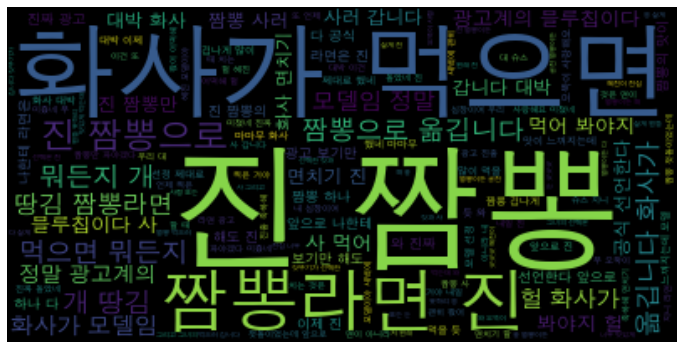

In [202]:
# http://deepsix2757.blogspot.com/2018/07/python-wordcloud.html
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image


wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(ko_alls)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

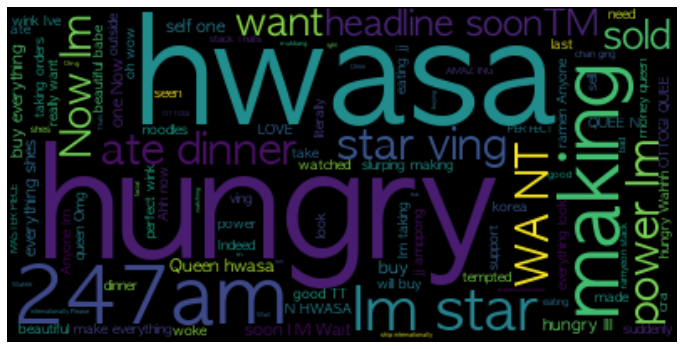

In [203]:
# http://deepsix2757.blogspot.com/2018/07/python-wordcloud.html
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image


wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(en_alls)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

### for 10 most liked comments

- ver) ko, eng

In [204]:
# 10 most liked for each language
ko_20s = ''
en_20s = ''
for i in range(len(kos)):
    ko_20s+= (kos['Comment'].loc[i] + " ")*int(kos['Like'].loc[i])
for i in range(len(engs)):
    en_20s+= (engs['Comment'].loc[i] + " ")*int(engs['Like'].loc[i])

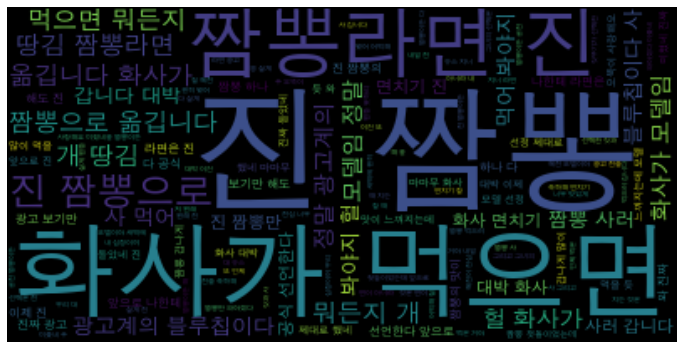

In [205]:
# http://deepsix2757.blogspot.com/2018/07/python-wordcloud.html
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image


wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(ko_20s)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

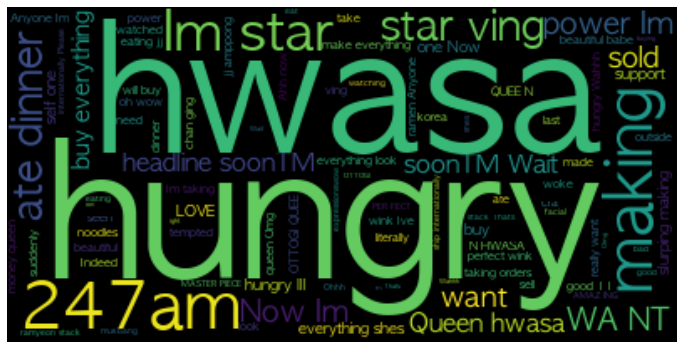

In [206]:
# http://deepsix2757.blogspot.com/2018/07/python-wordcloud.html
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image


wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(en_20s)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

## step 5) sentimental analysis 

In [182]:
def normalize(num):
    if num>0: return num/2+0.5 # ÏñëÏàòÎäî 0.5~1ÏùòÏà´ÏûêÎ°ú 
    else: return 0.5+num/2 #ÏùåÏàòÎäî 0~0.5Ïùò Ïà´ÏûêÎ°ú

In [252]:
sentis = []
eng_sentis = []
ko_sentis = []

for i in range(len(kos)):
    result = predict_pos_text(kos['Comment'].loc[i])
    ko_sentis.append(result)
    for j in range(int(kos['Like'].loc[i])):
        sentis.append(result)

for i in range(len(engs)):
    vs = analyzer.polarity_scores(engs['Comment'].loc[i]) 
    # VADERÎäî (-1, 1) Í∑∏Îü¨ÎÇò DNNÏùÄ (0,1)Ïù¥ÎØÄÎ°ú Ïù¥Î•º ÏúÑÌï¥ scale Î≥ÄÍ≤Ω 
    result = normalize(vs['compound'])
    eng_sentis.append(result)
    for j in range(int(engs['Like'].loc[i])):
        sentis.append(result)

In [256]:
# visualization
def my_plot(title_name, data_list):
    #plt.hist(data_list, range=(0,1), bins=25)
    plt.title(title_name)
    plt.xlabel('<--     negative            [scores]             positive     -->')
    plt.ylabel('count')
    # Plot histogram.
    cm = plt.cm.get_cmap('RdYlBu_r')
    n, bins, patches = plt.hist(data_list, 25, color='green', alpha = 0.8, edgecolor = 'black', linewidth = 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    plt.show()

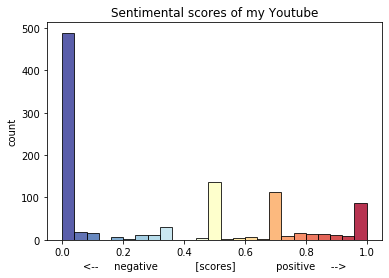

In [257]:
my_plot('Sentimental scores of my Youtube', sentis)

In [ ]:
my_plot('Sentimental scores of my Youtube', sentis)